In [58]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt
import time
import os
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from tests import test_prediction, test_generation

In [59]:
# load all that we need

dataset = np.load('../dataset/wiki.train.npy', allow_pickle=True)
devset = np.load('../dataset/wiki.valid.npy', allow_pickle=True)
fixtures_pred = np.load('../fixtures/prediction.npz')  # dev
fixtures_gen = np.load('../fixtures/generation.npy')  # dev
fixtures_pred_test = np.load('../fixtures/prediction_test.npz')  # test
fixtures_gen_test = np.load('../fixtures/generation_test.npy')  # test
vocab = np.load('../dataset/vocab.npy')

In [60]:
# set device as per system
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [61]:
# data loader


class LanguageModelDataLoader(DataLoader):
    """
        TODO: Define data loader logic here
    """
    def __init__(self, dataset, batch_size, shuffle=True):
        self.dataset, self.batch_size, self.shuffle = dataset, batch_size, shuffle 

    def __iter__(self):
        # concatenate dataset articles into single string
        # dataset shape: (579,), dataset[0].shape: (3803,)
        concatenate_string = np.concatenate(self.dataset) # concatenated shape: (2075677,)
        
        # generate input, output sequences eg: I ate an apple -> inp_seq: I ate an, out_seq: ate an apple
        # (also convert to torch tensors)
        input_sequence = torch.as_tensor(concatenate_string[:-1]) # first element to second last element 
        output_sequence = torch.as_tensor(concatenate_string[1:]) # second element to last element

        # calculate excess length while batching and truncate it off
        excess_length = len(input_sequence)%self.batch_size
        truncated_length = len(input_sequence) - excess_length
        input_sequence, output_sequence = input_sequence[:truncated_length], output_sequence[:truncated_length]

        # convert to long tensors
        input_sequence, output_sequence = (input_sequence).type(torch.LongTensor), (output_sequence).type(torch.LongTensor)


        # batch the input and output sequences
        num_batches = truncated_length // self.batch_size
        input_sequence = input_sequence.reshape(self.batch_size, num_batches)
        output_sequence = output_sequence.reshape(self.batch_size, num_batches)
        # print(f'input sequence: {input_sequence.shape} \noutput sequence: {output_sequence.shape}')

        # YIELD single batch of input, output for each batch (since we are designing an iter)
        prev = curr = 0 # current index for indexing data from sequences
        while curr < num_batches:
            # random BPTT length, https://arxiv.org/pdf/1708.02182.pdf section 5
            bptt_length = self.random_length()
            prev = curr
            curr += bptt_length
            yield input_sequence[:, prev:curr], output_sequence[:, prev:curr]


    # random BPTT length, https://arxiv.org/pdf/1708.02182.pdf section 5
    def random_length(self):
        random_probability = np.random.random_sample()
        if random_probability > 0.95:
            bptt_length = np.random.normal(70, 5)
        else:
            bptt_length = np.random.normal(35, 5)
        return round(bptt_length) #round off so we have integers


        
# test code
loader = LanguageModelDataLoader(dataset=dataset, batch_size=60, shuffle=True)
loader.__iter__()
# print(f'x:{x.shape}, y:{y.shape}')

<generator object LanguageModelDataLoader.__iter__ at 0x7f79c86de050>

In [62]:
# model

class LanguageModel(nn.Module):
    """
        TODO: Define your model here
    """
    def __init__(self, vocab_size):
        super(LanguageModel, self).__init__()
        # embedding size = 400 (https://arxiv.org/pdf/1708.02182.pdf section 5)
        self.embedding = nn.Embedding(num_embeddings = vocab_size, embedding_dim = 400) # simple lookup table that stores embeddings of a fixed dictionary and size
        # hidden size = 1150 (https://arxiv.org/pdf/1708.02182.pdf section 5)
        self.lstm = nn.LSTM(input_size=400, hidden_size=1150, num_layers=3, batch_first=True)
        # linear output = vocabulary size
        self.linear = nn.Linear(in_features=1150, out_features=vocab_size)

    def forward(self, x, hiddens=None):
        # Feel free to add extra arguments to forward (like an argument to pass in the hiddens)
        # embedding
        embeddings = self.embedding(x) 
        # lstm / rnn
        out, hiddens = self.lstm(embeddings, hiddens) if hiddens else self.lstm(embeddings) #operate on hidden states only if they are available
        # linear
        out = self.linear(out) 
        return out, hiddens

model = LanguageModel(len(vocab))
print(model)

LanguageModel(
  (embedding): Embedding(33278, 400)
  (lstm): LSTM(400, 1150, num_layers=3, batch_first=True)
  (linear): Linear(in_features=1150, out_features=33278, bias=True)
)


In [63]:
# model hyperparameters
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-6

In [64]:
# model trainer
import time 

class LanguageModelTrainer:
    def __init__(self, model, loader, max_epochs=1, run_id='exp'):
        """
            Use this class to train your model
        """
        # feel free to add any other parameters here
        self.model = model
        self.loader = loader
        self.train_losses = []
        self.val_losses = []
        self.predictions = []
        self.predictions_test = []
        self.generated_logits = []
        self.generated = []
        self.generated_logits_test = []
        self.generated_test = []
        self.epochs = 0
        self.max_epochs = max_epochs
        self.run_id = run_id
        
        # TODO: Define your optimizer and criterion here
        self.optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY) #
        self.criterion = nn.CrossEntropyLoss()

    def train(self):
        self.model.train() # set to training mode
        epoch_loss = 0
        num_batches = 0
        start_time = time.time()
        for batch_num, (inputs, targets) in enumerate(self.loader):
            if batch_num % 50 == 0:
                print(f'batch : {batch_num} \ttotal time elapsed : {round(time.time()-start_time, 2)} sec')
            epoch_loss += self.train_batch(inputs, targets)
        epoch_loss = epoch_loss / (batch_num + 1)
        self.epochs += 1
        print('[TRAIN]  Epoch [%d/%d]   Loss: %.4f'
                      % (self.epochs + 1, self.max_epochs, epoch_loss))
        print(f'time taken = {round((time.time()-start_time)/60, 2)} min')
        self.train_losses.append(epoch_loss)

    def train_batch(self, inputs, targets):
        """ 
            TODO: Define code for training a single batch of inputs
        
        """
        # initialize and move to the active device (make sure everything (inputs, model, outputs, targets) on same device)
        self.optimizer.zero_grad()
        inputs = inputs.to(device)
        targets = targets.to(device)

        # get output from model
        outputs, _ = self.model(inputs)

        # reshape outputs and targets
        outputs = outputs.reshape(-1, outputs.shape[2])
        targets = targets.reshape(-1)
        
        # judge quality of output against the target using loss function
        loss = self.criterion(outputs, targets)
        
        # optimize weights
        loss.backward()
        self.optimizer.step()
        return loss

    
    def test(self):
        # don't change these
        self.model.eval() # set to eval mode
        predictions = TestLanguageModel.prediction(fixtures_pred['inp'], self.model) # get predictions
        self.predictions.append(predictions)
        generated_logits = TestLanguageModel.generation(fixtures_gen, 10, self.model) # generated predictions for 10 words
        generated_logits_test = TestLanguageModel.generation(fixtures_gen_test, 10, self.model)
        nll = test_prediction(predictions, fixtures_pred['out'])
        generated = test_generation(fixtures_gen, generated_logits, vocab)
        generated_test = test_generation(fixtures_gen_test, generated_logits_test, vocab)
        self.val_losses.append(nll)
        
        self.generated.append(generated)
        self.generated_test.append(generated_test)
        self.generated_logits.append(generated_logits)
        self.generated_logits_test.append(generated_logits_test)
        
        # generate predictions for test data
        predictions_test = TestLanguageModel.prediction(fixtures_pred_test['inp'], self.model) # get predictions
        self.predictions_test.append(predictions_test)
            
        print('[VAL]  Epoch [%d/%d]   Loss: %.4f'
                      % (self.epochs + 1, self.max_epochs, nll))
        print('='*60)
        return nll

    def save(self):
        # don't change these
        model_path = os.path.join('experiments', self.run_id, 'model-{}.pkl'.format(self.epochs))
        torch.save({'state_dict': self.model.state_dict()},
            model_path)
        np.save(os.path.join('experiments', self.run_id, 'predictions-{}.npy'.format(self.epochs)), self.predictions[-1])
        np.save(os.path.join('experiments', self.run_id, 'predictions-test-{}.npy'.format(self.epochs)), self.predictions_test[-1])
        np.save(os.path.join('experiments', self.run_id, 'generated_logits-{}.npy'.format(self.epochs)), self.generated_logits[-1])
        np.save(os.path.join('experiments', self.run_id, 'generated_logits-test-{}.npy'.format(self.epochs)), self.generated_logits_test[-1])
        with open(os.path.join('experiments', self.run_id, 'generated-{}.txt'.format(self.epochs)), 'w') as fw:
            fw.write(self.generated[-1])
        with open(os.path.join('experiments', self.run_id, 'generated-{}-test.txt'.format(self.epochs)), 'w') as fw:
            fw.write(self.generated_test[-1])


In [65]:
class TestLanguageModel:
    def prediction(inp, model):
        """
            TODO: write prediction code here
            
            :param inp:
            :return: a np.ndarray of logits
        """
        # every input across notebook needs to be converted to long tensor
        # convert inputs to long tensor
        inp = torch.LongTensor(inp)
        # move to active device 
        inp = inp.to(device)
        # get model output
        out, out_lengths = model(inp)
        out = out[:, -1]

        # detatch logits array from tensor
        predictions = out.cpu().detach().numpy()
        return predictions

        
    def generation(inp, forward, model):
        """
            TODO: write generation code here

            Generate a sequence of words given a starting sequence.
            :param inp: Initial sequence of words (batch size, length)
            :param forward: number of additional words to generate
            :return: generated words (batch size, forward)
        """         
        model.eval()
        with torch.no_grad():
            result = [] # array of strings of length = forward
            # change to long type
            inp = torch.LongTensor(inp)
            # move inputs to device
            inp = inp.to(device)
            hidden = None
            for i in range(forward):
                out, hidden = model(inp, hidden) if hidden else model(inp) # pass in hidden input only if available
                predictions = torch.argmax(out, dim=2) 
                predictions = predictions[:,-1]
                inp = predictions.unsqueeze(1)
                result.append(inp)
        # concatenate result shape
        result = torch.cat(result, dim=1)

        # detatch words array from tensor
        result = result.cpu().detach().numpy()        
        return result

In [66]:
# TODO: define other hyperparameters here

NUM_EPOCHS = 6 # based on writeup
BATCH_SIZE = 80 # based on https://arxiv.org/pdf/1708.02182.pdf section 5

In [67]:
run_id = str(int(time.time()))
if not os.path.exists('./experiments'):
    os.mkdir('./experiments')
os.mkdir('./experiments/%s' % run_id)
print("Saving models, predictions, and generated words to ./experiments/%s" % run_id)

Saving models, predictions, and generated words to ./experiments/1639367590


In [68]:
loader = LanguageModelDataLoader(dataset=dataset, batch_size=BATCH_SIZE, shuffle=True)
model = LanguageModel(len(vocab))
model = model.to(device)
trainer = LanguageModelTrainer(model=model, loader=loader, max_epochs=NUM_EPOCHS, run_id=run_id)

In [69]:
print(f'length of dataloader = {len(loader.dataset)}')

length of dataloader = 579


In [70]:
best_nll = 1e30
for epoch in range(NUM_EPOCHS):
    trainer.train()
    nll = trainer.test()
    if nll < best_nll:
        best_nll = nll
        print("Saving model, predictions and generated output for epoch "+str(epoch)+" with NLL: "+ str(best_nll))
        trainer.save()

batch : 0 	total time elapsed : 0.01 sec
batch : 50 	total time elapsed : 36.66 sec
batch : 100 	total time elapsed : 72.51 sec
batch : 150 	total time elapsed : 110.1 sec
batch : 200 	total time elapsed : 148.35 sec
batch : 250 	total time elapsed : 185.83 sec
batch : 300 	total time elapsed : 223.14 sec
batch : 350 	total time elapsed : 260.06 sec
batch : 400 	total time elapsed : 297.58 sec
batch : 450 	total time elapsed : 336.45 sec
batch : 500 	total time elapsed : 374.18 sec
batch : 550 	total time elapsed : 411.69 sec
batch : 600 	total time elapsed : 449.06 sec
batch : 650 	total time elapsed : 487.18 sec
batch : 700 	total time elapsed : 522.77 sec
[TRAIN]  Epoch [2/6]   Loss: 7.0571
time taken = 8.82 min
[VAL]  Epoch [2/6]   Loss: 6.0492
Saving model, predictions and generated output for epoch 0 with NLL: 6.0492325
batch : 0 	total time elapsed : 0.01 sec
batch : 50 	total time elapsed : 35.89 sec
batch : 100 	total time elapsed : 71.38 sec
batch : 150 	total time elapsed : 

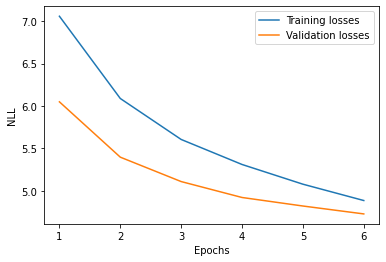

In [72]:
# Don't change these
# plot training curves
plt.figure()
plt.plot(range(1, trainer.epochs + 1), trainer.train_losses, label='Training losses')
plt.plot(range(1, trainer.epochs + 1), trainer.val_losses, label='Validation losses')
plt.xlabel('Epochs')
plt.ylabel('NLL')
plt.legend()
plt.show()

In [73]:
# see generated output
print (trainer.generated[-1]) # get last generated output

Input | Output #0: while the group was en route , but only three were ultimately able to attack . None of them were | not damaged , and the ship was completed . <eol>
Input | Output #1: <unk> , where he remained on loan until 30 June 2010 . <eol> = = = Return to Manchester United | = = = <eol> = = = <unk> = =
Input | Output #2: 25 April 2013 , denoting shipments of 500 @,@ 000 copies . <eol> The song became One Direction 's fourth | single , and the first single in the United States
Input | Output #3: , and Bruce R. ) one daughter ( Wendy J. <unk> ) and two grandchildren , died in <unk> , | <unk> , and the <unk> of the <unk> <unk> <unk>
Input | Output #4: Warrior were examples of this type . Because their armor was so heavy , they could only carry a single | <unk> . <eol> = = = <unk> = = =
Input | Output #5: the embassy at 1 : 49 and landed on Guam at 2 : 23 ; twenty minutes later , Ambassador | in the United States . <eol> = = = <unk>
Input | Output #6: <unk> , $ 96 million USD ) . Da